In [1]:
import torch
from torchvision import datasets, transforms

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Converts images to PyTorch tensors and normalizes pixel values to [0, 1]
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1] (mean=0.5, std=0.5 for single channel images)
])

# Load Fashion-MNIST dataset
train_dataset = datasets.FashionMNIST(
    root='./data',  # Directory to store/download the dataset
    train=True,     # Load the training set
    download=True,  # Download if not already available
    transform=transform  # Apply transformations
) #sirf trainnhi chhaye just seeing generator

# Access the images in the training set
images_train = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))])

# Print the shape to verify
print(f"Shape of images_train: {images_train.shape}")  # Expected: (60000, 1, 28, 28)


100%|██████████| 26.4M/26.4M [00:09<00:00, 2.85MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 209kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.90MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.02MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Shape of images_train: torch.Size([60000, 1, 28, 28])


In [2]:


# Random dimension size
randomDim = 100
# to introduce noise

# Normalize the images to range [-1, 1]
images_train = images_train.view(-1, 28*28).float()  # Flatten images and ensure float32 type
images_train = (images_train - 127.5) / 127.5

# Check the shape
print(f"Shape of images_train: {images_train.shape}")  # Expected: (60000, 784)


Shape of images_train: torch.Size([60000, 784])


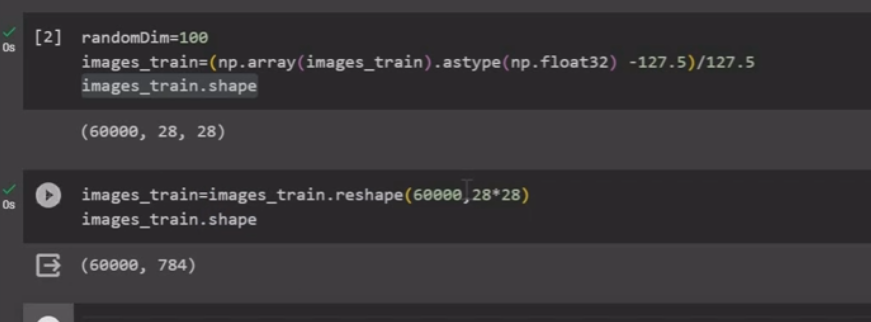

Shape of images_train: torch.Size([60000, 784])


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [5]:
# discriminator as compared to gnerator simple hota

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

# Random dimension size
randomDim = 100

# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(randomDim, 256),  # Input dimension is randomDim
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),  # Output dimension for 28x28 images
            nn.Tanh()  # [-1, 1] range
            # sigmoid [0,1] output krta we dont want that and tanh makes traning faster too tanh ko bd mn scale up krllenge to 0-255
        )

    def forward(self, x):
        return self.model(x)

# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),  # Input dimension is 784 (28x28 images flattened)
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),  # Output dimension for binary classification
            nn.Sigmoid()  # [0, 1] range
        )

    def forward(self, x):
        return self.model(x)

# Instantiate models
generator = Generator()
discriminator = Discriminator()

# Optimizers (Adam with default betas similar to Keras)
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function (Binary Cross-Entropy)
criterion = nn.BCELoss() #to output 0 and 1 fake or real


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the GAN (generator + discriminator combined)
class GAN(nn.Module):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def forward(self, z):
        # Generate images
        generated_images = self.generator(z)
        # Pass generated images through discriminator
        gan_output = self.discriminator(generated_images)
        return gan_output

# Freeze the discriminator's parameters when training the GAN
discriminator.requires_grad_(False)

# Instantiate the GAN model
gan = GAN(generator, discriminator)

# Optimizer for the GAN (same as generator since discriminator is frozen)
gan_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Loss function
criterion = nn.BCELoss()

# Example usage
randomDim = 100
z = torch.randn(64, randomDim)  # Random noise input
gan_output = gan(z)  # Forward pass through GAN


In [8]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plotGeneratedImages(epoch, generator, randomDim, examples=100, dim=(10, 10), figsize=(10, 10)):
    # Generate random noise
    noise = torch.randn(examples, randomDim)  # PyTorch equivalent of np.random.normal
    # Generate images using the generator
    with torch.no_grad():  # Disable gradient calculation for inference
        generatedImages = generator(noise).cpu().numpy()  # Convert to NumPy array
    # Reshape images to (28, 28)
    generatedImages = generatedImages.reshape(examples, 28, 28)

    # Plot the images
    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generatedImages[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'gan_generated_image_epoch_{epoch}.png')


In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

def train(generator, discriminator, gan, images_train, randomDim, epochs=1, batchSize=128):
    # Calculate the number of batches
    batchCount = int(images_train.shape[0] / batchSize)

    print('Epochs:', epochs)
    print('Batch size:', batchSize)
    print('Batches per epoch:', batchCount)

    # Loss function
    criterion = torch.nn.BCELoss()

    # Optimizers
    generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    for e in range(1, epochs + 1):
        print('-' * 15, f'Epoch {e}', '-' * 15)
        for _ in range(batchCount):
            # Generate random noise
            noise = torch.randn(batchSize, randomDim)
            # Sample a batch of real images
            indices = np.random.randint(0, images_train.shape[0], size=batchSize)
            imageBatch = torch.tensor(images_train[indices], dtype=torch.float32)

            # Reshape and normalize the real images
            imageBatch = imageBatch.view(batchSize, -1)  # Flatten 28x28 to 784
            imageBatch = (imageBatch - 127.5) / 127.5  # Normalize to [-1, 1]

            # Generate fake images
            generatedImages = generator(noise)

            # Concatenate real and fake images
            X = torch.cat([imageBatch, generatedImages])

            # Labels for discriminator
            yDis = torch.cat([
                torch.ones(batchSize) * 0.9,  # Smoothed real labels ye 0,9 h isntead of 1 cuz we dont want discriminator to be suoer good we just want it to be good
                torch.zeros(batchSize)       # Fake labels
            ])

            # Train discriminator
            discriminator_optimizer.zero_grad()
            discriminator_outputs = discriminator(X)
            dloss = criterion(discriminator_outputs.squeeze(), yDis)
            dloss.backward()
            discriminator_optimizer.step()

            # Train generator
            noise = torch.randn(batchSize, randomDim)
            yGen = torch.ones(batchSize)  # Labels for generator (all real)

            generator_optimizer.zero_grad()
            discriminator.requires_grad_(False)  # Freeze discriminator weights
            gan_outputs = gan(noise)
            gloss = criterion(gan_outputs.squeeze(), yGen)
            gloss.backward()
            generator_optimizer.step()
            discriminator.requires_grad_(True)  # Unfreeze discriminator weights

        # Plot generated images every 5 epochs or at the first epoch
        if e == 1 or e % 5 == 0:
            plotGeneratedImages(epoch=e, generator=generator, randomDim=randomDim)

# Example usage:
# train(generator, discriminator, gan, images_train, randomDim=100, epochs=10, batchSize=128)


Epochs: 9
Batch size: 128
Batches per epoch: 468
--------------- Epoch 1 ---------------


<ipython-input-9-803698e72a66>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  imageBatch = torch.tensor(images_train[indices], dtype=torch.float32)


--------------- Epoch 2 ---------------
--------------- Epoch 3 ---------------
--------------- Epoch 4 ---------------
--------------- Epoch 5 ---------------
--------------- Epoch 6 ---------------
--------------- Epoch 7 ---------------
--------------- Epoch 8 ---------------
--------------- Epoch 9 ---------------


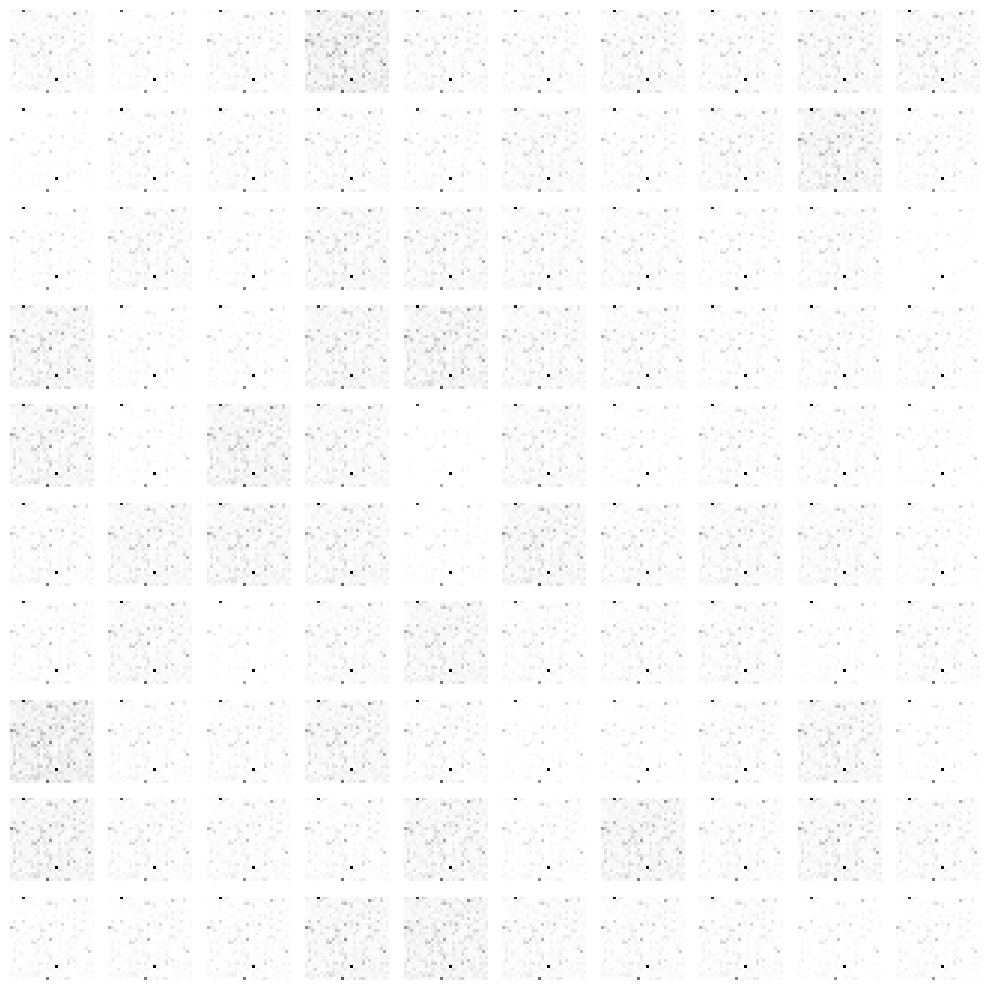

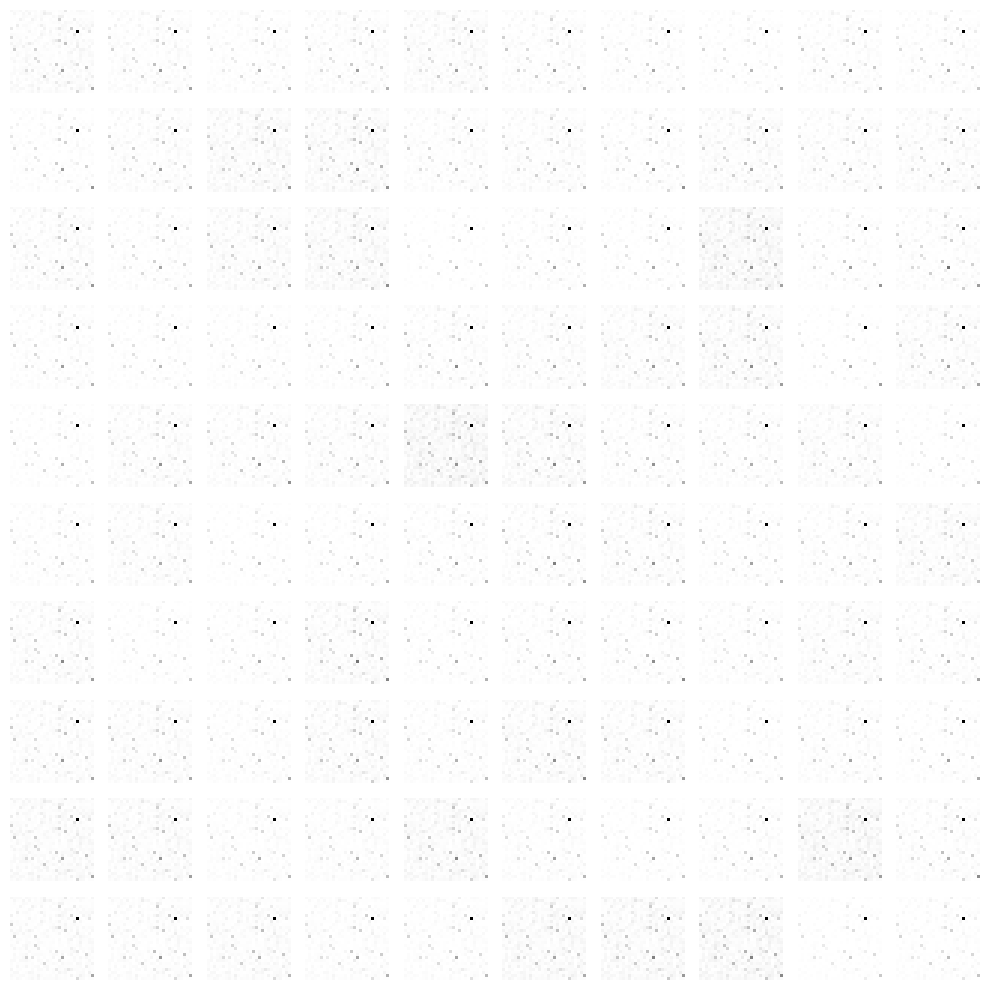

In [12]:
train(generator, discriminator, gan, images_train, randomDim=100, epochs=9, batchSize=128)

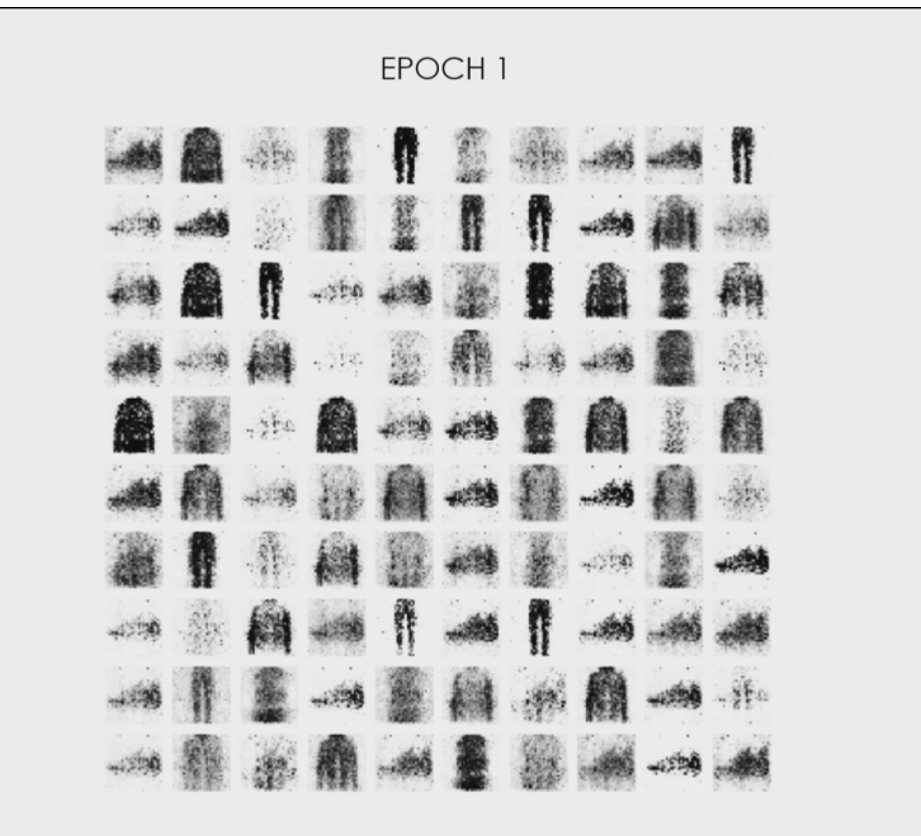

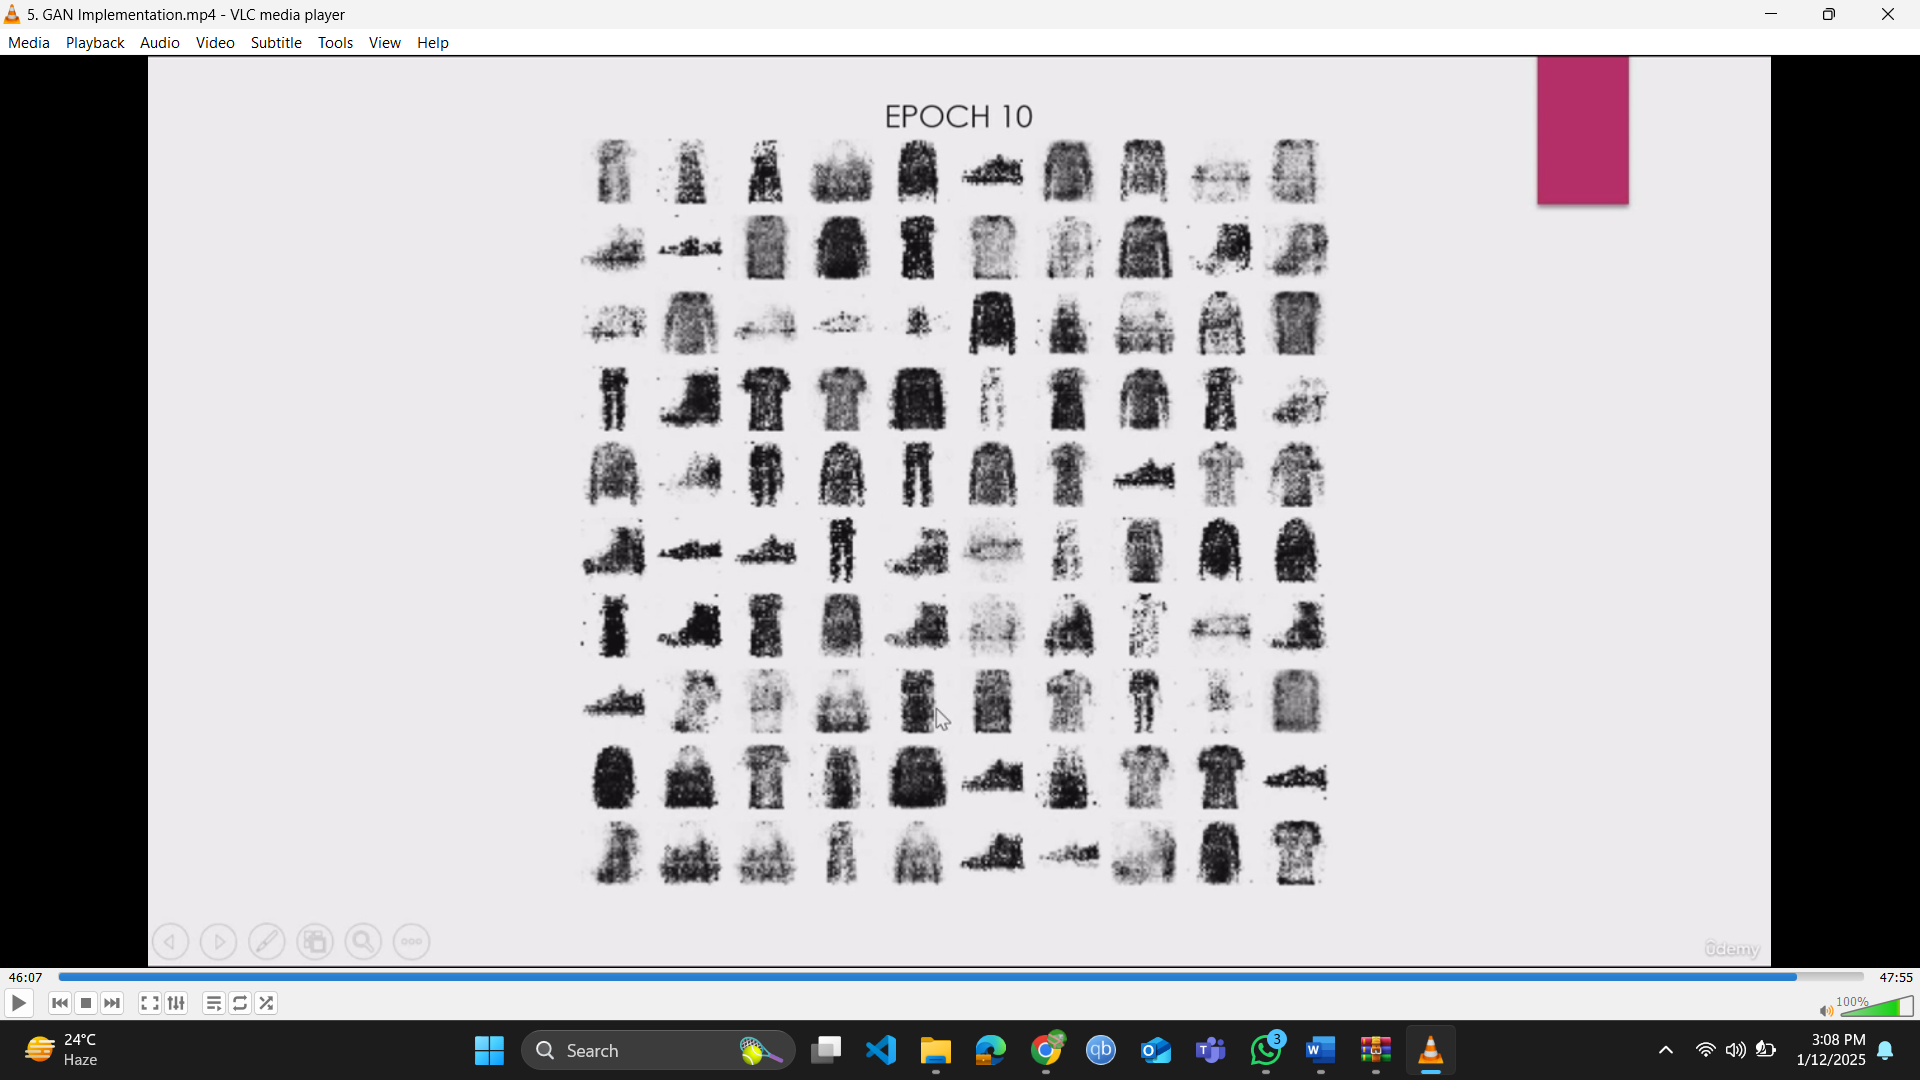

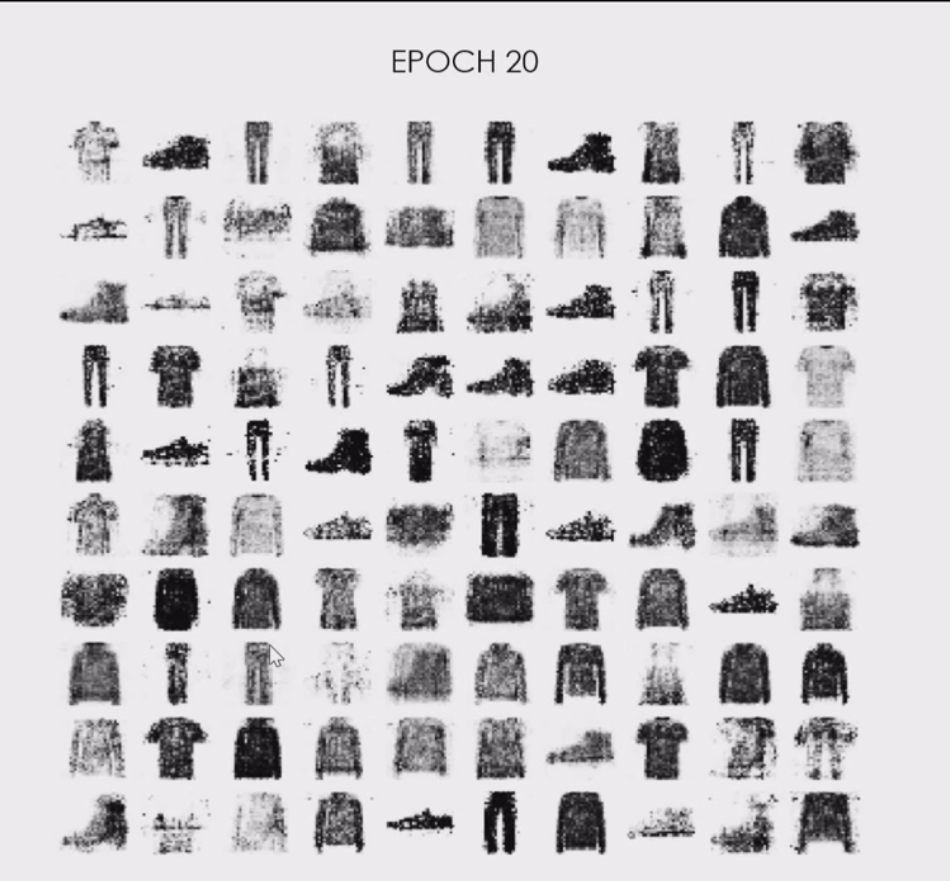

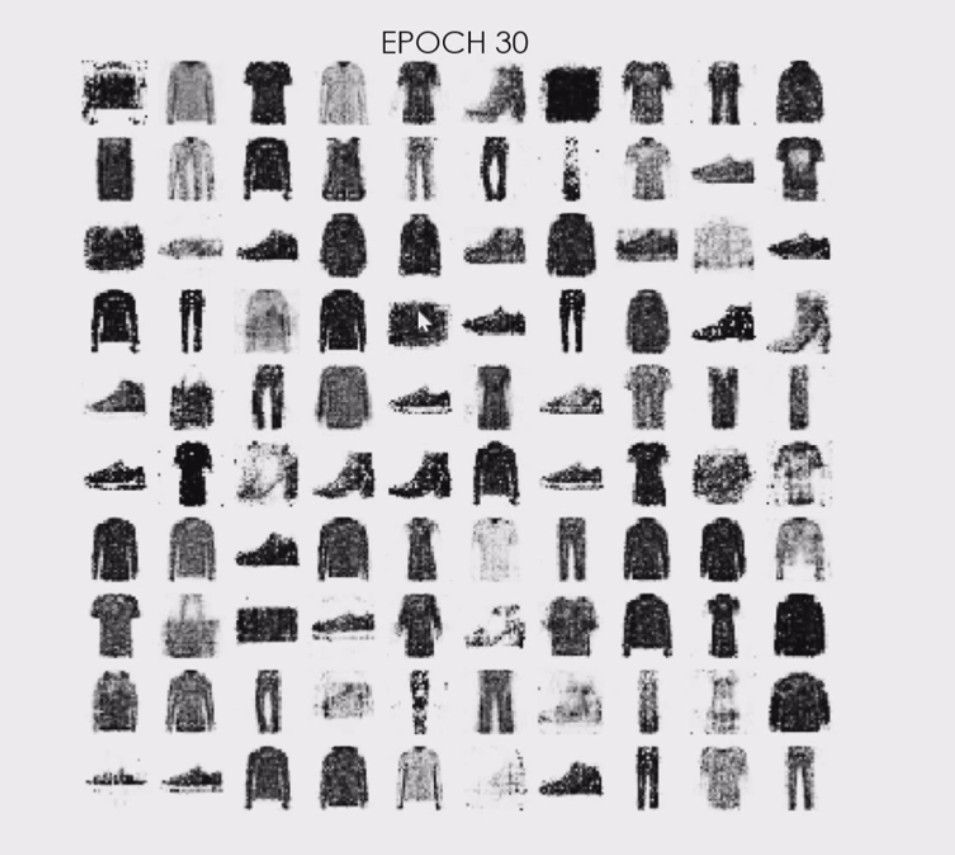

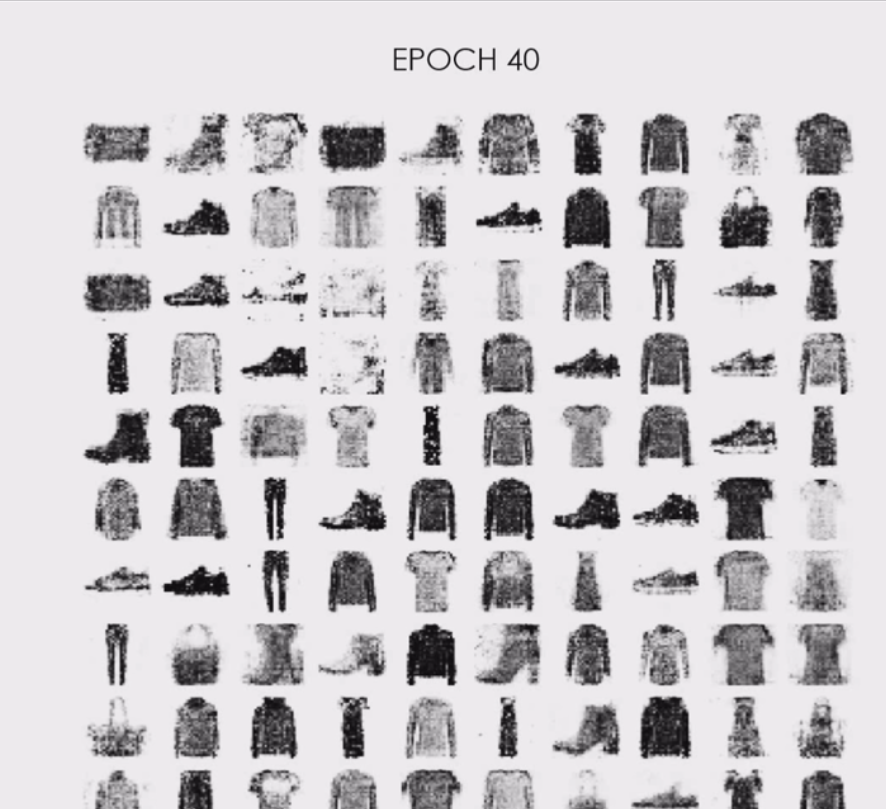